<a href="https://www.kaggle.com/code/aisuko/image-captioning?scriptVersionId=164951382" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Image captioning is the task of predicting a caption for a given image. Common real world applications of it include aiding visually impaired poeple that can help them navigate through different situations. Therefore, image captioning helps to improve content accessibility for people by describing images to them. As you can see here, we will fine-tune an image captioning model and use it for inference.

In [1]:
%%capture
!pip install transformers==4.35.2
!pip install bitsandbytes==0.41.3
!pip install accelerate==0.25.0
!pip install peft==0.7.1
!pip install datasets==2.15.0
!pip install evaluate==0.4.1
!pip install jiwer==3.0.3

In [2]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tuning ms-git-base-pokemon-blip-captions"
os.environ["WANDB_NOTES"] = "Fine tune model distilbert base uncased"
os.environ["WANDB_NAME"] = "ft-ms-git-base-pokemon-blip-captions"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Loading the Pokemon BLIP captions dataset

Here we are going to load dataset that consists of image-caption pairs. [With the custom dataset for image captioning](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/GIT/Fine_tune_GIT_on_an_image_captioning_dataset.ipynb)

In [3]:
from datasets import load_dataset

ds=load_dataset("lambdalabs/pokemon-blip-captions", split="train[:500]")
ds

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 500
})

The dataset has two features, image and text. We will split the dataset's train split and test set.

In [4]:
ds=ds.train_test_split(test_size=0.3)
train_ds=ds["train"]
test_ds=ds["test"]
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 350
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 150
    })
})


# Visualization Some Samples

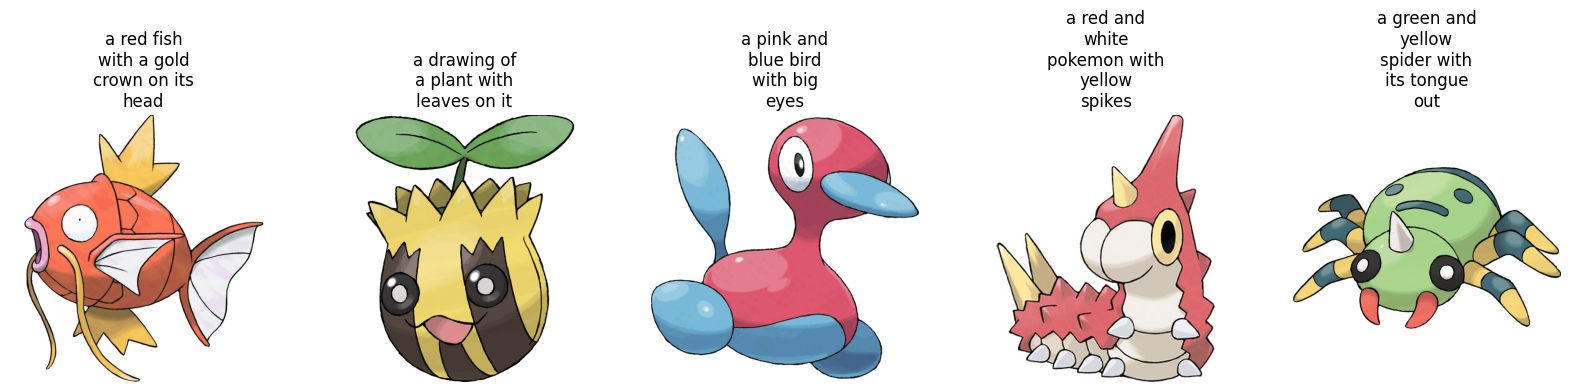

In [5]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, captions):
    plt.figure(figsize=(20,20))
    for i in range(len(images)):
        ax=plt.subplot(1, len(images),i+1)
        caption=captions[i]
        caption="\n".join(wrap(caption,12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

sample_images_to_visualize=[np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions=[train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

# Preprocess the datasest

Since the dataset has two modalities(image and text), the pre-processing pipeline will preprocess images and the captions. To do so, we need to load the processor class associated with the model we are abou to fine-tune.

In [6]:
from transformers import AutoProcessor

model_checkpoint="microsoft/git-base"
processor=AutoProcessor.from_pretrained(model_checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [7]:
def transforms(example_batch):
    images=[x for x in example_batch["image"]]
    captions=[x for x in example_batch["text"]]
    inputs=processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels":inputs["input_ids"]})
    return inputs

train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

# Loading a Base Model

In [8]:
import torch
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM

bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True
)


model=AutoModelForCausalLM.from_pretrained(
    model_checkpoint,
    quantization_config=bnb_config,
    trust_remote_code=True,
    torch_dtype=torch.float16)
print(model.device)
print(model)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

cuda:0
GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear4bit(in_features=768, out_features=768, bias=True)
                (v_proj): Linear4bit(in_features=768, out_features=768, bias=True

In [9]:
from peft import prepare_model_for_kbit_training

#gradient checkpointing to save memory
model.gradient_checkpointing_enable()

prepared_model=prepare_model_for_kbit_training(
    model, use_gradient_checkpointing=True
)

prepared_model.get_memory_footprint()

320446224

In [10]:
from peft import LoraConfig, get_peft_model, TaskType

peft_config=LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'out_proj',
        'fc1',
        'fc2',
        'query',
        'key',
        'value',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)

lora_model=get_peft_model(prepared_model, peft_config)
lora_model.get_memory_footprint

<bound method PreTrainedModel.get_memory_footprint of GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=768, out_features=7

# Evaluate
Image captioning models are typically evaluated with the [Rouge Score] or [Word Error Rate]. Here, we will use the Word Error Rate(WER). We use the Evaluate library to do so.

In [11]:
from evaluate import load
import torch

wer=load("wer")

def compute_metrics(eval_pred):
    logits, labels =eval_pred
    predicted=logits.argmax(-1)
    decoded_labels=processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions=processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score=wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

# Training

In [12]:
from transformers import TrainingArguments, Trainer

training_args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    learning_rate=5e-5,
    num_train_epochs=5,
    fp16=True,
    per_device_train_batch_size=4, # to fit lower memory GPUs
    per_device_eval_batch_size=4, # to fit lower memory GPUs, it can be 16 or 32
    gradient_accumulation_steps=4,
    warmup_steps=50,
    max_steps=100,
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    save_steps=50,
    logging_steps=20,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to="wandb", # or report_to="tensorboard"
    run_name=os.getenv("WANDB_NAME"),
)

trainer=Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [ ]:
# no enough GPU memeory
# trainer.evaluate()

In [ ]:
processor.push_to_hub(os.getenv("WANDB_NAME"))
trainer.push_to_hub(os.getenv("WANDB_NAME"))

# Inference

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
device="cuda"
inputs=processor(images=image, return_tensors="pt").to(device)
pixel_values=inputs.pixel_values

In [ ]:
generated_ids=model.generate(pixel_values=pixel_values, max_length=50)
generated_caption=processor.batch_decode(generated_ids, skip_special_token=True)[0]
print(generated_caption)